# Installs & Imports

In [1]:
!pip install keras-nlp -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 84.9 MB/s eta 0:00:00


In [2]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Standard imports
import math
import datetime
import os
import random
import json

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import (
    layers, models, preprocessing, utils, callbacks, optimizers
)
from tensorflow.data import Dataset
import keras_nlp

# Set random seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Using TensorFlow backend


# Loading the Data

In [3]:
# Download and extract the dataset
dataset_url = 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip'
path_to_zip = utils.get_file("cornell_movie_dialogs.zip", origin=dataset_url, extract=True)
path_to_dataset = os.path.join(os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")
path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

9916637/9916637 [==============================] - 2s 0us/step


In [4]:
# Function to load conversations
def load_conversations():
    # Load and map the movie lines with their IDs
    id_to_line = {}
    with open(path_to_movie_lines, encoding='utf-8', errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        id_to_line[parts[0]] = parts[4]

    # Process conversations and pair lines
    inputs, outputs = [], []
    # Initialize the sample count
    sample_count = 0
    with open(path_to_movie_conversations, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
        for i in range(len(conversation) - 1):
            inputs.append(id_to_line[conversation[i]])
            outputs.append(id_to_line[conversation[i + 1]])
            # Increment sample count
            sample_count += 1
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs, sample_count
    return inputs, outputs, sample_count

In [5]:
# Load and process conversations
MAX_SAMPLES = 100000
inputs, outputs, sample_count = load_conversations()
print(f"Total number of samples: {sample_count}")

Total number of samples: 100000


# Splitting the Data

In [6]:
# Split the data into training and validation sets
train_dataset = Dataset.from_tensor_slices((inputs[:80000], outputs[:80000]))
val_dataset = Dataset.from_tensor_slices((inputs[80000:], outputs[80000:]))

In [7]:
# Verify the dataset shapes
train_to_numpy = list(train_dataset.as_numpy_iterator())
train_shape = tf.shape(train_to_numpy)
print(f"Training dataset shape:")
print(train_shape)
print("\n")

val_to_numpy = list(val_dataset.as_numpy_iterator())
val_shape = tf.shape(val_to_numpy)
print(f"Validation dataset shape:")
print(val_shape)
print("\n")

Training dataset shape:
tf.Tensor([80000     2], shape=(2,), dtype=int32)


Validation dataset shape:
tf.Tensor([20000     2], shape=(2,), dtype=int32)




In [8]:
# Print the first five training examples
print(f"Training Examples:")
for i in range(5):
    print(f"Input: {inputs[i]}")
    print(f"Output: {outputs[i]}")
    print()

# Print the first five validation examples
print(f"Validation Examples:")
for i in range(5):
    print(f"Input: {inputs[80000+i]}")
    print(f"Output: {outputs[80000+i]}")
    print()

Training Examples:
Input: Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Output: Well, I thought we'd start with pronunciation, if that's okay with you.

Input: Well, I thought we'd start with pronunciation, if that's okay with you.
Output: Not the hacking and gagging and spitting part.  Please.

Input: Not the hacking and gagging and spitting part.  Please.
Output: Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

Input: You're asking me out.  That's so cute. What's your name again?
Output: Forget it.

Input: No, no, it's my fault -- we didn't have a proper introduction ---
Output: Cameron.

Validation Examples:
Input: I know what this is...I picked you up when I was drunk and you probably thought I'm just fucked up enough to fall for this. But the thing is I know what I'm doing when I drink. I just usually don't care. Right now, I do though. And I want you out. Now.
Output:

# Preprocessing the Data

## Text Cleaning Function

In [9]:
# Function to preprocess the text
def preprocess_text(sequence):
    # Convert to lowercase
    sequence = tf.strings.lower(sequence)
    # Add space around punctuation and replace multiple spaces with a single space
    sequence = tf.strings.regex_replace(sequence, r"([?.!,])", r" \1 ")
    # Replace multiple spaces with a single space
    sequence = tf.strings.regex_replace(sequence, r"\s\s+", " ")
    # Allow English characters and digits, remove other characters
    sequence = tf.strings.regex_replace(sequence, r"[^a-z0-9?.!,]+", " ")
    sequence = tf.strings.strip(sequence)
    # Add BOS and EOS tokens
    sequence = tf.strings.join(["[BOS]", sequence, "[EOS]"], separator=" ")
    return sequence

## Text Vectorization Layer

In [10]:
VOCAB_SIZE = 50000
MAX_LENGTH = 40

# Create the vectorizer
vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=preprocess_text,
    output_mode='int',
    output_sequence_length=MAX_LENGTH
)

# Adapt the vectorizer to the inputs and outputs
vectorizer.adapt(Dataset.from_tensor_slices((inputs + outputs)).batch(1024))

In [11]:
# Function to vectorize the text
def vectorize_text(inputs, outputs):
    inputs, outputs = vectorizer(inputs), vectorizer(outputs)
    # Add an extra padding token to the right side to match output shape
    outputs = tf.pad(outputs, [[0, 1]])
    return (
        {"encoder_inputs": inputs, "decoder_inputs": outputs[:-1]},
        {"outputs": outputs[1:]},
    )

## TensorFlow Datasets

In [12]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64

# Tokenize and pad the datasets
train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

# Configure datasets for performance
train_dataset = (
    train_dataset.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset.cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
# Print tokenized training dataset examples
for example in train_dataset.take(1):
    print(example)

({'encoder_inputs': <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
array([[   4,    7,   48, ...,    0,    0,    0],
       [   4, 8294,    2, ...,    0,    0,    0],
       [   4,   18,   26, ...,    0,    0,    0],
       ...,
       [   4,   52,    6, ...,    0,    0,    0],
       [   4, 2430,    9, ...,    0,    0,    0],
       [   4,   80,    8, ...,    0,    0,    0]])>, 'decoder_inputs': <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
array([[   4,   22,  159, ...,    0,    0,    0],
       [   4, 1065,   19, ...,    0,    0,    0],
       [   4,   26,   34, ...,    0,    0,    0],
       ...,
       [   4,   73,   19, ...,    0,    0,    0],
       [   4,  141,   21, ...,    0,    0,    0],
       [   4,  116,    2, ...,    0,    0,    0]])>}, {'outputs': <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
array([[  22,  159,   51, ...,    0,    0,    0],
       [1065,   19,   13, ...,    0,    0,    0],
       [  26,   34, 1852, ...,    0,    0,    0],
       ...,
       [  73,

# Building the Model

## FNet Encoder

In [14]:
# FNet encoder class
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding dimension for the encoder layer
        self.embed_dim = embed_dim
        # Dimension for the dense projection layers
        self.dense_dim = dense_dim

        # Dense projection layers: first with ReLU activation, then a linear layer
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation='relu'),
                layers.Dense(embed_dim),
            ]
        )

        # Layer normalization
        self.layer_norm_1 = layers.LayerNormalization()
        self.layer_norm_2 = layers.LayerNormalization()

    def call(self, inputs):
        # Casting the inputs to complex64 for Fast Fourier Transform (FFT)
        inputs_complex = tf.cast(inputs, tf.complex64)

        # Applying 2D FFT to project inputs to frequency domain
        # then taking the real part of the FFT output
        fft_output = tf.math.real(tf.signal.fft2d(inputs_complex))

        # Adding the original inputs to the FFT output followed by layer normalization
        proj_input = self.layer_norm_1(inputs + fft_output)

        # Applying the dense projection to the normalized FFT output
        proj_output = self.dense_proj(proj_input)

        # Adding the input to the output of dense layers followed by another layer normalization
        return self.layer_norm_2(proj_input + proj_output)

## Positional Embedding

In [15]:
# Positional embedding class
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for tokens
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        # Embedding layer for token positions
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        # Save sequence length, vocabulary size, and embedding dimension
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        # Calculate the length of the input sequence
        length = tf.shape(inputs)[-1]
        # Generate position indices
        positions = tf.range(start=0, limit=length, delta=1)
        # Embed tokens and positions
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        # Return sum of tokens and position embeddings
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        # Create a mask for non-zero inputs
        return tf.math.not_equal(inputs, 0)

## FNet Decoder

In [16]:
# FNet decoder class
class FNetDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Embedding and latent dimensions, and number of attention heads
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        # First multi-head attention layer (self-attention)
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        # Second multi-head attention layer (encoder-decoder attention)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        # Dense projection layers
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation='relu'),
                layers.Dense(embed_dim),
            ]
        )
        # Layer normalization
        self.layer_norm_1 = layers.LayerNormalization()
        self.layer_norm_2 = layers.LayerNormalization()
        self.layer_norm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        # Generate causal attention mask for self-attention
        causal_mask = self.get_causal_attention_mask(inputs)
        # Combine causal mask with padding mask if provided
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype='int32')
            padding_mask = tf.minimum(padding_mask, causal_mask)

        # Apply self-attention and add & norm
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layer_norm_1(inputs + attention_output_1)

        # Apply encoder-decoder attention and add & norm
        attention_output_2 = self.attention_2(
            query=out_1, value=encoder_outputs, key=encoder_outputs, attention_mask=padding_mask
        )
        out_2 = self.layer_norm_2(out_1 + attention_output_2)

        # Apply dense projection and final layer norm
        proj_output = self.dense_proj(out_2)
        return self.layer_norm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        # Generate a causal attention mask to mask future tokens
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype='int32')
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        # Tile the mask for all batches
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

## Model Function

In [17]:
EMBED_DIM = 256
LATENT_DIM = 512
NUM_HEADS = 8

# Function to create the FNet model
def create_model():
    # Define inputs for the encoder
    encoder_inputs = keras.Input(shape=(None,), dtype='int32', name='encoder_inputs')
    # Apply positional embedding to encoder inputs
    x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(encoder_inputs)
    # Apply FNet encoder
    encoder_outputs = FNetEncoder(EMBED_DIM, LATENT_DIM)(x)
    # Define the encoder model
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    # Define inputs for the decoder
    decoder_inputs = keras.Input(shape=(None,), dtype='int32', name='decoder_inputs')

    # Encoded sequence inputs
    encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name='decoder_state_inputs')

    # Apply positional embedding to decoder inputs
    x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(decoder_inputs)
    # Apply FNet decoder
    x = FNetDecoder(EMBED_DIM, LATENT_DIM, NUM_HEADS)(x, encoded_seq_inputs)

    # Apply dropout and final dense layer for output prediction
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(VOCAB_SIZE, activation='softmax')(x)
    # Define the decoder model
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name='outputs')
    # Apply the decoder to the encoder outputs
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])

    # Create the FNet model
    fnet = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name='fnet')
    return fnet

## Model Compilation

Model: "fnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            1281024   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                         0                                       
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                             

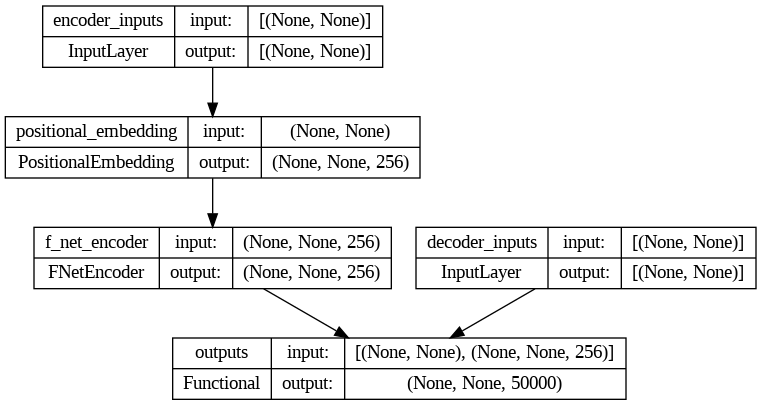

In [ ]:
# Instantiate the FNet model
fnet = create_model()

# Compile the model
learning_rate = 1e-4
optimizer = optimizers.Adam(learning_rate=learning_rate)
perplexity = keras_nlp.metrics.Perplexity(from_logits=False, mask_token_id=0,
                                          name="perplexity")

fnet.compile(optimizer=optimizer,
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=[perplexity])

# Print the model
fnet.summary()

# Visualize the model
utils.plot_model(fnet, show_shapes=True)

## Training the Model

In [ ]:
# Define callbacks
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_perplexity', patience=5, mode='min',
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='fnet_model.tf', monitor='val_perplexity',
                                       save_best_only=True, mode='min', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_perplexity', factor=0.1,
                                         patience=1, min_lr=1e-10, mode='min', verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir)
]

In [ ]:
EPOCHS = 30

# Train the model
history_fnet = fnet.fit(train_dataset,
                        epochs=EPOCHS,
                        validation_data=val_dataset,
                        callbacks=callbacks)

Epoch 1/30


1250/1250 [==============================] - ETA: 0s - loss: 5.3239 - perplexity: 273.0990
Epoch 1: val_perplexity improved from inf to 119.51940, saving model to fnet_model.tf
1250/1250 [==============================] - 233s 179ms/step - loss: 5.3239 - perplexity: 273.0990 - val_loss: 4.4554 - val_perplexity: 119.5194 - lr: 1.0000e-04
Epoch 2/30
1250/1250 [==============================] - ETA: 0s - loss: 4.3853 - perplexity: 110.4338
Epoch 2: val_perplexity improved from 119.51940 to 98.71896, saving model to fnet_model.tf
1250/1250 [==============================] - 210s 168ms/step - loss: 4.3853 - perplexity: 110.4338 - val_loss: 4.2764 - val_perplexity: 98.7190 - lr: 1.0000e-04
Epoch 3/30
1250/1250 [==============================] - ETA: 0s - loss: 4.2151 - perplexity: 92.0690
Epoch 3: val_perplexity improved from 98.71896 to 90.71103, saving model to fnet_model.tf
1250/1250 [==============================] - 209s 167ms/step - loss: 4.2151 - perplexity: 92.0690 - val_loss: 4.1976

# Evaluating the Model

In [ ]:
# Launch TensorBoard
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [ ]:
# Load the best saved model
custom_objects = {
    'FNetEncoder': FNetEncoder,
    'PositionalEmbedding': PositionalEmbedding,
    'FNetDecoder': FNetDecoder
}

best_fnet = models.load_model('fnet_model.tf', custom_objects=custom_objects)

In [ ]:
# Evaluating the model on the validation set
fnet_loss, fnet_perplexity = best_fnet.evaluate(val_dataset)
print(f'Validation Loss: {fnet_loss}')
print(f'Validation Perplexity: {fnet_perplexity}')

313/313 [==============================] - 26s 80ms/step - loss: 4.7248 - perplexity: 159.8790
Validation Loss: 4.724791526794434
Validation Perplexity: 159.87896728515625


## Plotting the Metrics

In [18]:
# Function to plot the training history
def plot_training_history(history):
    perp = history.history['perplexity']
    val_perp = history.history['val_perplexity']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(perp) + 1)

    # Plot the perplexities
    plt.plot(epochs, perp, 'skyblue', label='Training Perplexity')
    plt.plot(epochs, val_perp, 'orange', label='Validation Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.legend()
    plt.figure()

    # Plot the losses
    plt.plot(epochs, loss, 'skyblue', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

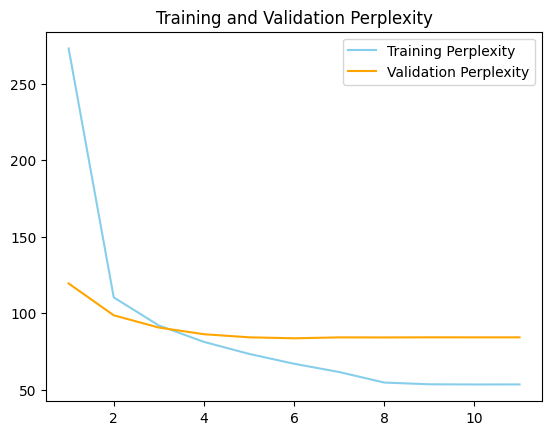

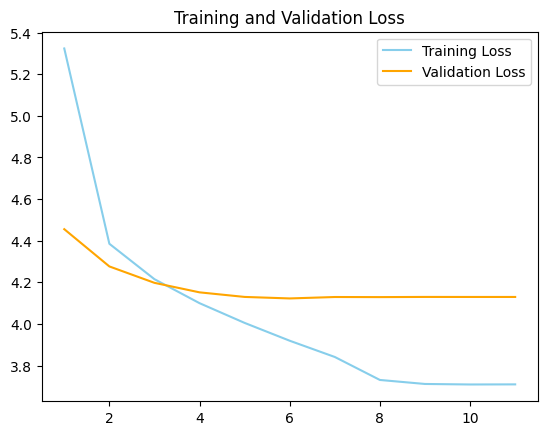

In [ ]:
# Call the function
plot_training_history(history_fnet)

# Inferencing With the Model

In [ ]:
VOCAB = vectorizer.get_vocabulary()

# Function to decode the input sequence with the model
def decode_sequence(input_sequence):
    # Map the inputs sequence to tokens and add the BOS and EOS tokens
    tokenized_input_sequence = vectorizer(
        tf.constant("[BOS] " + preprocess_text(input_sequence) + " [EOS]")
    )

    # Initialize the sequence with only the BOS token
    tokenized_target_sequence = tf.expand_dims(VOCAB.index("[BOS]"), 0)
    # Initialize the decoded sequence
    decoded_sequence = ""

    # Generate the sequence
    for i in range(MAX_LENGTH):
        # Get the model predictions
        predictions = best_fnet.predict(
            {
                "encoder_inputs": tf.expand_dims(tokenized_input_sequence, 0),
                "decoder_inputs": tf.expand_dims(
                    tf.pad(
                        tokenized_target_sequence,
                        [[0, MAX_LENGTH - tf.shape(tokenized_target_sequence)[0]]],
                    ),
                    0,
                ),
            }
        )
        # Calculate the token with the highest probability
        sampled_token_index = tf.argmax(predictions[0, i, :])
        # Get the corresponding word
        sampled_token = VOCAB[sampled_token_index.numpy()]
        # If sampled token is EOS token, then stop generating
        if tf.equal(sampled_token_index, VOCAB.index("[EOS]")):
            break
        # Append the sampled token to the decoded sequence
        decoded_sequence += sampled_token + " "
        # Append the sampled token to the target sequence
        tokenized_target_sequence = tf.concat(
            [tokenized_target_sequence, [sampled_token_index]], 0
        )

    return decoded_sequence.strip()

In [ ]:
# Call the function
print(decode_sequence("How are you doing today?"))

1/1 [==============================] - 0s 24ms/step
oh , sir .


# Hyperparameter Tuning

In [19]:
from scipy.optimize import minimize

# Set the epochs for tuning
EPOCHS = 3

## Model Function

In [20]:
# Model creation function
def create_model(EMBED_DIM, LATENT_DIM, NUM_HEADS, learning_rate):
        # Ensure hyperparameters are positive integers
        EMBED_DIM = max(int(EMBED_DIM), 1)
        LATENT_DIM = max(int(LATENT_DIM), 1)
        NUM_HEADS = max(int(NUM_HEADS), 1)

        # Define inputs for the encoder
        encoder_inputs = keras.Input(shape=(None,), dtype='int32', name='encoder_inputs')
        # Apply positional embedding to encoder inputs
        x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(encoder_inputs)
        # Apply FNet encoder
        encoder_outputs = FNetEncoder(EMBED_DIM, LATENT_DIM)(x)
        # Define the encoder model
        encoder = keras.Model(encoder_inputs, encoder_outputs)

        # Define inputs for the decoder
        decoder_inputs = keras.Input(shape=(None,), dtype='int32', name='decoder_inputs')

        # Encoded sequence inputs
        encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name='decoder_state_inputs')

        # Apply positional embedding to decoder inputs
        x = PositionalEmbedding(MAX_LENGTH, VOCAB_SIZE, EMBED_DIM)(decoder_inputs)
        # Apply FNet decoder
        x = FNetDecoder(EMBED_DIM, LATENT_DIM, NUM_HEADS)(x, encoded_seq_inputs)

        # Apply dropout and final dense layer for output prediction
        x = layers.Dropout(0.5)(x)
        decoder_outputs = layers.Dense(VOCAB_SIZE, activation='softmax')(x)
        # Define the decoder model
        decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name='outputs')
        # Apply the decoder to the encoder outputs
        decoder_outputs = decoder([decoder_inputs, encoder_outputs])

        # Create the FNet model
        fnet = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name='fnet')
        return fnet

## Objective Function

In [21]:
# Global list to track the objective values
objective_values = []

# Define the objective function
def objective_function(hyperparams):
    try:
        # Unpack hyperparameters
        EMBED_DIM, LATENT_DIM, NUM_HEADS, learning_rate = hyperparams

        # Ensure hyperparameters are positive integers
        EMBED_DIM = max(int(EMBED_DIM), 1)
        LATENT_DIM = max(int(LATENT_DIM), 1)
        NUM_HEADS = max(int(NUM_HEADS), 1)

        # Create, compile, and train the model
        fnet = create_model(EMBED_DIM, LATENT_DIM, NUM_HEADS, learning_rate)
        optimizer = optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
        perplexity_metric = keras_nlp.metrics.Perplexity(from_logits=False, mask_token_id=0, name="perplexity")
        fnet.compile(optimizer=optimizer,
                     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=[perplexity_metric])
        history_fnet = fnet.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

        # Return the final perplexity
        final_perplexity = history_fnet.history['val_perplexity'][-1]

        # Append the perplexity value to the global list
        objective_values.append(final_perplexity)

        return final_perplexity

    except Exception as e:
        print("An error occurred:", e)
        objective_values.append(np.inf)  # Append a large number in case of error
        return np.inf  # Return a large number in case of error

## Nelder Mead Algorithm

In [22]:
# Initial guess for hyperparameters
initial_guess = [256, 512, 8, 1e-4]

# Nelder-Mead algorithm for optimization
result = minimize(
    objective_function,
    initial_guess,
    method='Nelder-Mead',
    options={'maxiter': 5, 'maxfev': 20})

# Extract the best hyperparameters and score
best_hyperparams = result.x
best_score = result.fun

print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Score: {best_score}")

Epoch 1/3


1250/1250 [==============================] - 233s 177ms/step - loss: 5.3238 - perplexity: 273.0810 - val_loss: 4.4552 - val_perplexity: 119.4910
Epoch 2/3
1250/1250 [==============================] - 212s 169ms/step - loss: 4.3850 - perplexity: 110.3943 - val_loss: 4.2751 - val_perplexity: 98.5805
Epoch 3/3
1250/1250 [==============================] - 211s 169ms/step - loss: 4.2145 - perplexity: 92.0136 - val_loss: 4.1965 - val_perplexity: 90.6059
Epoch 1/3


1250/1250 [==============================] - 266s 207ms/step - loss: 5.2758 - perplexity: 261.8741 - val_loss: 4.4431 - val_perplexity: 117.9619
Epoch 2/3
1250/1250 [==============================] - 241s 193ms/step - loss: 4.3732 - perplexity: 109.0214 - val_loss: 4.2700 - val_perplexity: 98.0489
Epoch 3/3
1250/1250 [==============================] - 239s 191ms/step - loss: 4.2064 - perplexity: 91.2033 - val_loss: 4.2001 - val_perplexity: 90.9509
Epoch 1/3


1250/1250 [==============================] - 233s 181ms/step - loss: 5.3084 - perplexity: 269.7843 - val_loss: 4.4639 - val_perplexity: 120.6128
Epoch 2/3
1250/1250 [==============================] - 213s 170ms/step - loss: 4.3953 - perplexity: 111.6308 - val_loss: 4.2881 - val_perplexity: 99.9627
Epoch 3/3
1250/1250 [==============================] - 212s 170ms/step - loss: 4.2257 - perplexity: 93.1246 - val_loss: 4.2049 - val_perplexity: 91.4344
Epoch 1/3


1250/1250 [==============================] - 232s 181ms/step - loss: 5.3092 - perplexity: 269.4634 - val_loss: 4.4556 - val_perplexity: 119.5435
Epoch 2/3
1250/1250 [==============================] - 213s 170ms/step - loss: 4.3887 - perplexity: 110.8270 - val_loss: 4.2806 - val_perplexity: 99.1611
Epoch 3/3
1250/1250 [==============================] - 212s 170ms/step - loss: 4.2214 - perplexity: 92.6918 - val_loss: 4.2023 - val_perplexity: 91.1763
Epoch 1/3


1250/1250 [==============================] - 232s 180ms/step - loss: 5.2864 - perplexity: 264.8178 - val_loss: 4.4441 - val_perplexity: 118.0941
Epoch 2/3
1250/1250 [==============================] - 212s 170ms/step - loss: 4.3770 - perplexity: 109.4740 - val_loss: 4.2751 - val_perplexity: 98.5868
Epoch 3/3
1250/1250 [==============================] - 211s 169ms/step - loss: 4.2094 - perplexity: 91.5346 - val_loss: 4.1972 - val_perplexity: 90.6736
Epoch 1/3


1250/1250 [==============================] - 264s 206ms/step - loss: 5.2703 - perplexity: 259.9472 - val_loss: 4.4488 - val_perplexity: 118.6767
Epoch 2/3
1250/1250 [==============================] - 239s 191ms/step - loss: 4.3788 - perplexity: 109.6729 - val_loss: 4.2751 - val_perplexity: 98.5845
Epoch 3/3
1250/1250 [==============================] - 237s 190ms/step - loss: 4.2134 - perplexity: 91.9100 - val_loss: 4.2013 - val_perplexity: 91.0823
Epoch 1/3


1250/1250 [==============================] - 262s 204ms/step - loss: 5.2663 - perplexity: 259.3366 - val_loss: 4.4425 - val_perplexity: 117.8962
Epoch 2/3
1250/1250 [==============================] - 234s 187ms/step - loss: 4.3711 - perplexity: 108.7828 - val_loss: 4.2714 - val_perplexity: 98.1921
Epoch 3/3
1250/1250 [==============================] - 235s 188ms/step - loss: 4.2053 - perplexity: 91.1019 - val_loss: 4.1923 - val_perplexity: 90.1983
Epoch 1/3


1250/1250 [==============================] - 263s 205ms/step - loss: 5.2384 - perplexity: 252.1191 - val_loss: 4.4214 - val_perplexity: 115.2595
Epoch 2/3
1250/1250 [==============================] - 237s 189ms/step - loss: 4.3519 - perplexity: 106.5543 - val_loss: 4.2551 - val_perplexity: 96.4926
Epoch 3/3
1250/1250 [==============================] - 235s 188ms/step - loss: 4.1860 - perplexity: 89.2362 - val_loss: 4.1786 - val_perplexity: 88.8869
Epoch 1/3


1250/1250 [==============================] - 261s 203ms/step - loss: 5.2735 - perplexity: 261.1933 - val_loss: 4.4384 - val_perplexity: 117.3670
Epoch 2/3
1250/1250 [==============================] - 233s 187ms/step - loss: 4.3733 - perplexity: 109.0215 - val_loss: 4.2730 - val_perplexity: 98.3546
Epoch 3/3
1250/1250 [==============================] - 233s 187ms/step - loss: 4.2101 - perplexity: 91.5772 - val_loss: 4.1986 - val_perplexity: 90.8122
Epoch 1/3


1250/1250 [==============================] - 238s 184ms/step - loss: 5.2852 - perplexity: 263.8135 - val_loss: 4.4484 - val_perplexity: 118.6377
Epoch 2/3
1250/1250 [==============================] - 210s 168ms/step - loss: 4.3730 - perplexity: 108.9720 - val_loss: 4.2676 - val_perplexity: 97.7925
Epoch 3/3
1250/1250 [==============================] - 209s 167ms/step - loss: 4.2017 - perplexity: 90.7537 - val_loss: 4.1853 - val_perplexity: 89.5242
Best Hyperparameters: [2.70400e+02 4.92800e+02 7.35000e+00 1.05625e-04]
Best Score: 88.88685607910156


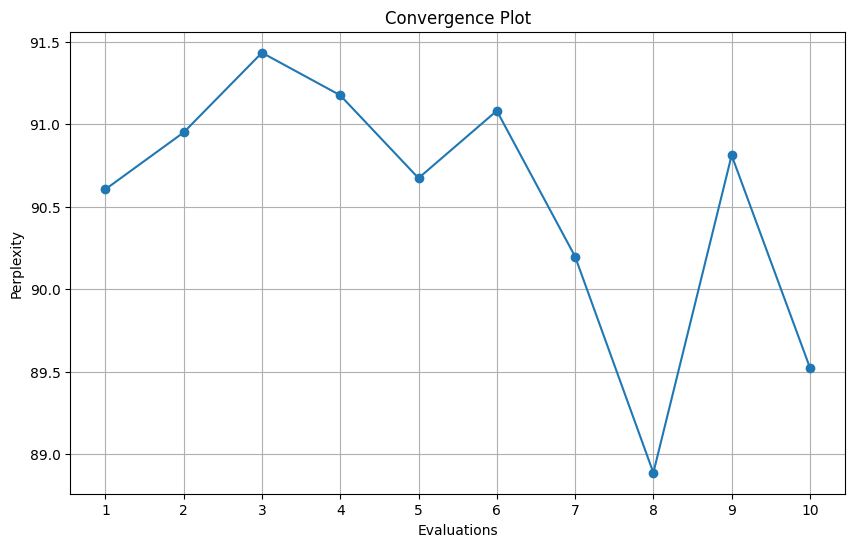

In [23]:
# Plot the convergence
plt.figure(figsize=(10, 6))
evaluation_numbers = range(1, len(objective_values) + 1)
plt.plot(evaluation_numbers, objective_values, marker='o')
plt.title("Convergence Plot")
plt.xlabel("Evaluations")
plt.ylabel("Perplexity")
plt.grid(True)
plt.xticks(evaluation_numbers)
plt.show()

In [24]:
# Save the best hyperparameters
hyperparams_dict = {
    "EMBED_DIM": int(best_hyperparams[0]),
    "LATENT_DIM": int(best_hyperparams[1]),
    "NUM_HEADS": int(best_hyperparams[2]),
    "LEARNING_RATE": best_hyperparams[3]
}

with open("best_hyperparams.json", "w") as file:
    json.dump(hyperparams_dict, file)

## Rebuilding the Model

Model: "fnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding_20 (P  (None, None, 270)            1351080   ['encoder_inputs[0][0]']      
 ositionalEmbedding)                                      0                                       
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                             

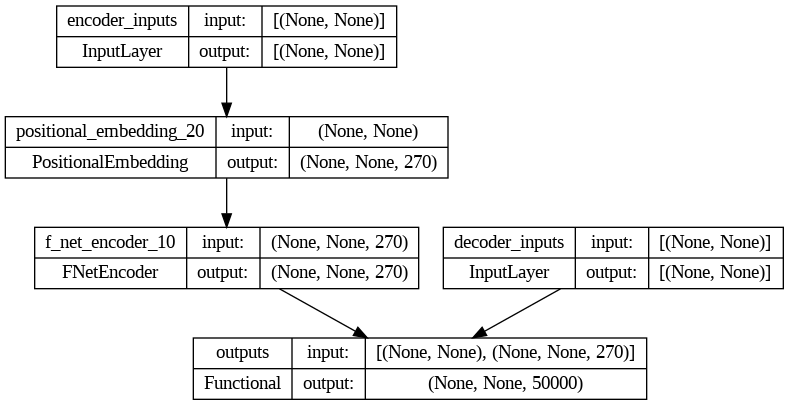

In [25]:
# Load hyperparameters
with open("best_hyperparams.json", "r") as file:
    loaded_hyperparams = json.load(file)

# Rebuild the model with the loaded hyperparameters
rebuilt_model = create_model(
    EMBED_DIM=loaded_hyperparams["EMBED_DIM"],
    LATENT_DIM=loaded_hyperparams["LATENT_DIM"],
    NUM_HEADS=loaded_hyperparams["NUM_HEADS"],
    learning_rate=loaded_hyperparams["LEARNING_RATE"]
)
optimizer = optimizers.Adam(learning_rate=loaded_hyperparams["LEARNING_RATE"])
perplexity_metric = keras_nlp.metrics.Perplexity(from_logits=False, mask_token_id=0, name="perplexity")
rebuilt_model.compile(optimizer=optimizer,
                     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=[perplexity_metric])

# Print the model
rebuilt_model.summary()

# Visualize the model
utils.plot_model(rebuilt_model, show_shapes=True)

In [26]:
# Define callbacks
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_perplexity', patience=5, mode='min',
                                     verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='tuned_model.tf', monitor='val_perplexity',
                                       save_best_only=True, mode='min', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_perplexity', factor=0.1,
                                         patience=1, min_lr=1e-10, mode='min', verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir)
]

## Training the Model

In [27]:
# Train the rebuilt model
EPOCHS = 30

history_rebuilt_model = rebuilt_model.fit(train_dataset,
                                          epochs=EPOCHS,
                                          validation_data=val_dataset,
                                          callbacks=callbacks)

Epoch 1/30


1250/1250 [==============================] - ETA: 0s - loss: 5.2485 - perplexity: 254.7924
Epoch 1: val_perplexity improved from inf to 115.84666, saving model to tuned_model.tf
1250/1250 [==============================] - 262s 204ms/step - loss: 5.2485 - perplexity: 254.7924 - val_loss: 4.4261 - val_perplexity: 115.8467 - lr: 1.0562e-04
Epoch 2/30
1250/1250 [==============================] - ETA: 0s - loss: 4.3554 - perplexity: 106.9804
Epoch 2: val_perplexity improved from 115.84666 to 96.71387, saving model to tuned_model.tf
1250/1250 [==============================] - 241s 193ms/step - loss: 4.3554 - perplexity: 106.9804 - val_loss: 4.2573 - val_perplexity: 96.7139 - lr: 1.0562e-04
Epoch 3/30
1250/1250 [==============================] - ETA: 0s - loss: 4.1899 - perplexity: 89.6221
Epoch 3: val_perplexity improved from 96.71387 to 89.45905, saving model to tuned_model.tf
1250/1250 [==============================] - 241s 192ms/step - loss: 4.1899 - perplexity: 89.6221 - val_loss: 4.1

In [28]:
# Load the best saved model
custom_objects = {
    'FNetEncoder': FNetEncoder,
    'PositionalEmbedding': PositionalEmbedding,
    'FNetDecoder': FNetDecoder
}

best_tuned = models.load_model('tuned_model.tf', custom_objects=custom_objects)

## Metrics Evaluation & Plotting

In [29]:
# Evaluating the model on the validation set
tuned_loss, tuned_perplexity = best_tuned.evaluate(val_dataset)
print(f'Validation Loss: {tuned_loss}')
print(f'Validation Perplexity: {tuned_perplexity}')

313/313 [==============================] - 26s 82ms/step - loss: 4.6262 - perplexity: 143.8432
Validation Loss: 4.62623929977417
Validation Perplexity: 143.84320068359375


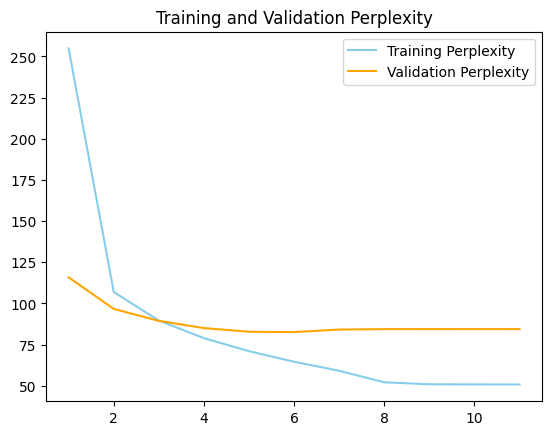

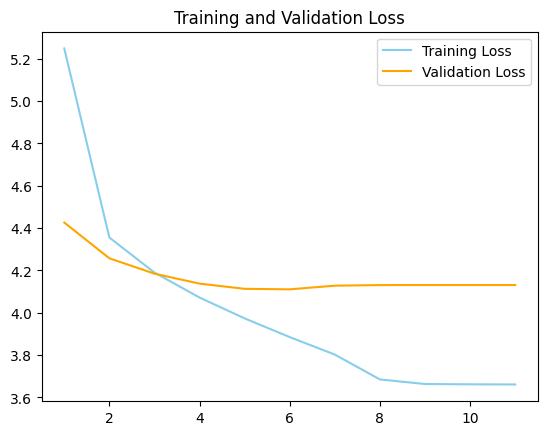

In [30]:
# Plot the history
plot_training_history(history_rebuilt_model)

## Inferencing Phase

In [31]:
VOCAB = vectorizer.get_vocabulary()

# Function to decode the input sequence with the model
def decode_sequence(input_sequence):
    # Map the inputs sequence to tokens and add the BOS and EOS tokens
    tokenized_input_sequence = vectorizer(
        tf.constant("[BOS] " + preprocess_text(input_sequence) + " [EOS]")
    )

    # Initialize the sequence with only the BOS token
    tokenized_target_sequence = tf.expand_dims(VOCAB.index("[BOS]"), 0)
    # Initialize the decoded sequence
    decoded_sequence = ""

    # Generate the sequence
    for i in range(MAX_LENGTH):
        # Get the model predictions
        predictions = best_tuned.predict(
            {
                "encoder_inputs": tf.expand_dims(tokenized_input_sequence, 0),
                "decoder_inputs": tf.expand_dims(
                    tf.pad(
                        tokenized_target_sequence,
                        [[0, MAX_LENGTH - tf.shape(tokenized_target_sequence)[0]]],
                    ),
                    0,
                ),
            }
        )
        # Calculate the token with the highest probability
        sampled_token_index = tf.argmax(predictions[0, i, :])
        # Get the corresponding word
        sampled_token = VOCAB[sampled_token_index.numpy()]
        # If sampled token is EOS token, then stop generating
        if tf.equal(sampled_token_index, VOCAB.index("[EOS]")):
            break
        # Append the sampled token to the decoded sequence
        decoded_sequence += sampled_token + " "
        # Append the sampled token to the target sequence
        tokenized_target_sequence = tf.concat(
            [tokenized_target_sequence, [sampled_token_index]], 0
        )

    return decoded_sequence.strip()

In [32]:
# Call the function
print(decode_sequence("How are you doing today?"))

1/1 [==============================] - 0s 23ms/step
and .


In [33]:
# Slightly revised function for decoding
def decode_sequence(input_sequence):
    # Preprocess and tokenize the input sequence
    tokenized_input_sequence = vectorizer(tf.constant(preprocess_text(input_sequence)))

    # Initialize the sequence with the BOS token index
    tokenized_target_sequence = tf.convert_to_tensor([VOCAB.index("[BOS]")], dtype=tf.int64)

    # Initialize the decoded sequence
    decoded_sequence = ""

    # Generate the sequence
    for i in range(MAX_LENGTH):
        padded_target_sequence = tf.pad(
            tokenized_target_sequence, [[0, MAX_LENGTH - tf.shape(tokenized_target_sequence)[0]]]
        )

        # Get the model predictions
        predictions = best_tuned.predict({
            "encoder_inputs": tf.expand_dims(tokenized_input_sequence, 0),
            "decoder_inputs": tf.expand_dims(padded_target_sequence, 0)
        })

        # Calculate the token with the highest probability
        sampled_token_index = tf.argmax(predictions[0, i, :]).numpy()
        sampled_token = VOCAB[sampled_token_index]

        # If sampled token is EOS token, then stop generating
        if sampled_token == "[EOS]":
            break

        decoded_sequence += sampled_token + " "
        tokenized_target_sequence = tf.concat([tokenized_target_sequence, [sampled_token_index]], 0)

    return decoded_sequence.strip()

# Call the function
input_sequence = "How are you doing today?"
print(decode_sequence(input_sequence))

1/1 [==============================] - 0s 23ms/step
and .
